In [1]:
#lib imports
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#local imports
from utils import *
from plotting import *
from model_creator import *
from mediapipe_utils.mediapipe_transforamtions import *

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Python version: ', os.sys.version)

TensorFlow version:  2.18.0
Keras version:  3.6.0
Python version:  3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:42:31) [MSC v.1937 64 bit (AMD64)]


In [2]:
local_dir = './'
original_data_dir = os.path.join(local_dir, 'src_data_mediapipe')
# src_data contains the original data from the Kaggle dataset together with the augmented data from 'resized_images'
dataset_dir = os.path.join(local_dir, 'dataset_mediapipe')
models_dir = os.path.join(local_dir, 'models_mediapipe')

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

src_data = os.path.join(local_dir, 'src_data')
assert os.path.exists(src_data), f'{src_data} not found'

classes = ['rock', 'paper', 'scissors']

if not os.path.exists(original_data_dir):
    create_rps_mediapipe_dataset(src_data, original_data_dir, classes, min_detection_confidence=0.4, input_shape=(224, 224), output_shape=(64, 64))

if not os.path.exists(original_data_dir):
    raise FileNotFoundError('Original data directory not found')

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    split_dataset(classes, original_data_dir, dataset_dir)

for path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(path):
        raise FileNotFoundError(f'{path} not found')
    
    print(path)
    for class_name in classes:
        print(f'    - {class_name}: {len(os.listdir(os.path.join(path, class_name)))} images')
  

./dataset_mediapipe\train
    - rock: 1580 images
    - paper: 1801 images
    - scissors: 1588 images
./dataset_mediapipe\val
    - rock: 197 images
    - paper: 225 images
    - scissors: 198 images
./dataset_mediapipe\test
    - rock: 198 images
    - paper: 226 images
    - scissors: 199 images


In [3]:
from utils import check_for_duplicates_in_dataset
check_for_duplicates_in_dataset('./dataset_mediapipe')

No duplicates found in dataset
6212 files found in dataset


Found 4969 images belonging to 3 classes.
Found 620 images belonging to 3 classes.
Found 623 images belonging to 3 classes.


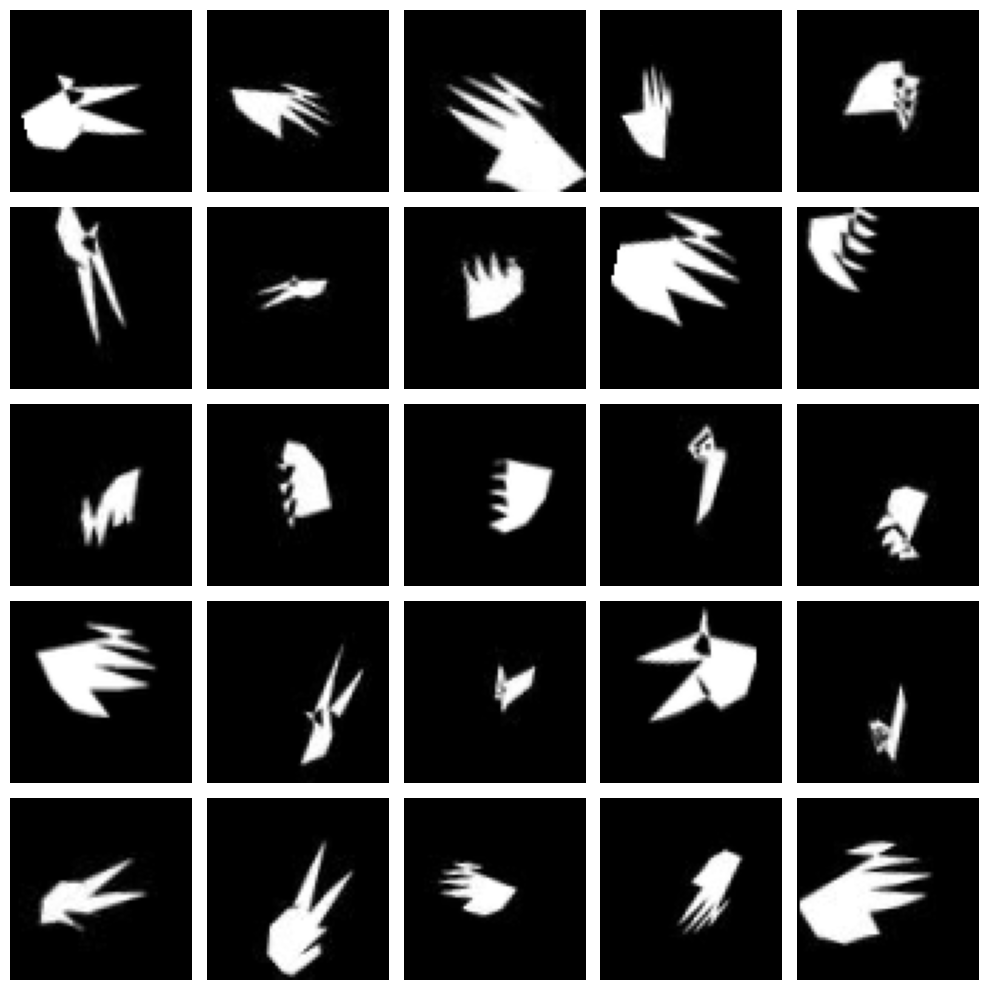

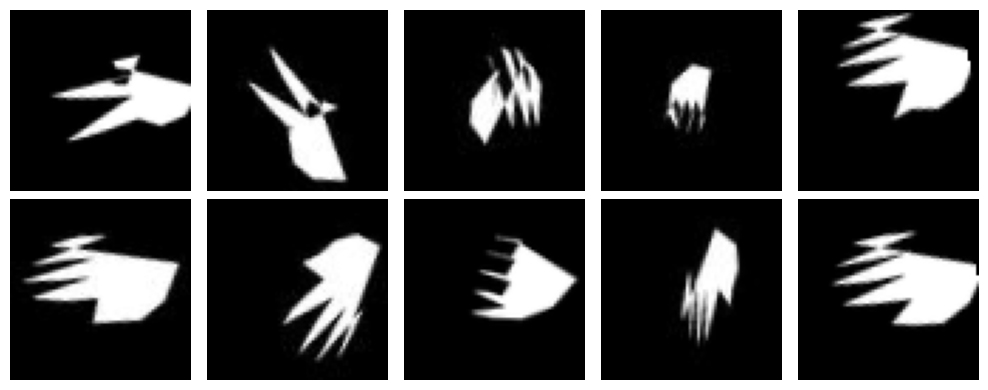

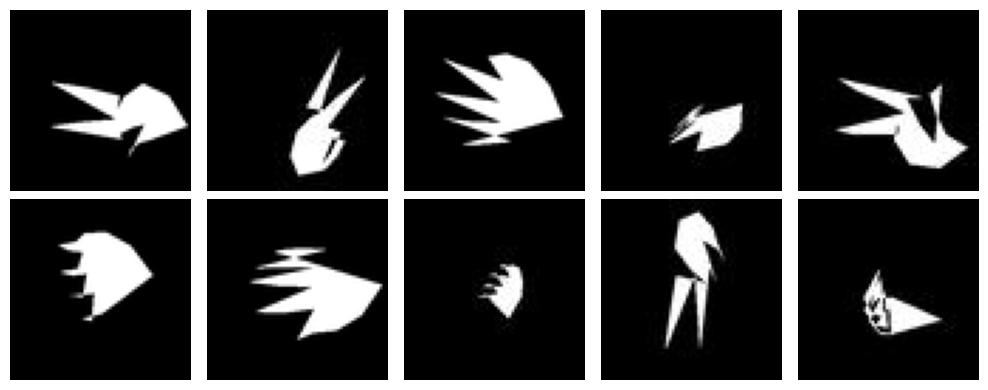

In [4]:
# Image target size
img_rows, img_cols = 64, 64
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    shear_range=0.1,  
    zoom_range=[0.8, 1.2], 
    horizontal_flip=True,  
    fill_mode='constant'  
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=[0.9, 1.1],
    fill_mode='constant'
    )
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    )

plot_grid_from_generator(train_generator, 5, 5, cmap='gray')
plot_grid_from_generator(val_generator, 2, 5, cmap='gray')
plot_grid_from_generator(test_generator, 2, 5, cmap='gray')

In [5]:
model_loaded = tf.keras.models.load_model(os.path.join(models_dir, 'cnn_mediapipe.keras'))
model_loaded.evaluate(test_generator)

c:\Users\adria\anaconda3\envs\ML\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - acc: 0.9493 - loss: 0.1775


[0.1379067748785019, 0.9630818367004395]

In [ ]:
raise Exception('Stop here')

In [5]:
EPOCHS = 50
MODEL_NAME = 'cnn_mediapipe'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(models_dir, f'{MODEL_NAME}_ckp.keras'),
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

csvlogger_callback = tf.keras.callbacks.CSVLogger(
    filename=os.path.join(models_dir, f'{MODEL_NAME}_ckp_history.csv'),     
    separator=',',                      
    append=True                           
)

# Channels: 1 for grayscale (3 for RGB), arg 'input_shape' in the model
hist_dict = compile_and_train_model(
    create_model_func=build_cnn_medium,
    create_model_args={'input_shape' : (64, 64, 1), 'num_classes' :3},
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'], 
    train_generator=train_generator,
    val_generator=val_generator,
    epochs=EPOCHS,
    models_dir=models_dir,
    model_name=MODEL_NAME,
    callbacks=[checkpoint_callback, csvlogger_callback]
)

c:\Users\adria\anaconda3\envs\ML\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\adria\anaconda3\envs\ML\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - acc: 0.6471 - loss: 0.8853 - val_acc: 0.3177 - val_loss: 2.3376
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - acc: 0.8755 - loss: 0.3709 - val_acc: 0.3629 - val_loss: 3.8891
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - acc: 0.8972 - loss: 0.2942 - val_acc: 0.4790 - val_loss: 1.9358
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - acc: 0.9105 - loss: 0.2642 - val_acc: 0.9242 - val_loss: 0.2177
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - acc: 0.9299 - loss: 0.2307 - val_acc: 0.8774 - val_loss: 0.3045
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - acc: 0.9369 - loss: 0.1938 - val_acc: 0.9548 - val_loss: 0.1430
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - acc: 0.9414 - loss: 0.1821 - val_acc: 0.9452 - val_loss: 0.1507
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - acc: 0.9386 - loss: 0.1854 - val_acc: 0.9226 - val_loss: 0.2160
Epoch 9/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - ac

In [6]:
model = tf.keras.models.load_model(os.path.join(models_dir, f'{MODEL_NAME}_ckp.keras'))
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

20/20 - 1s - 28ms/step - acc: 0.9807 - loss: 0.0703


<Figure size 640x480 with 0 Axes>

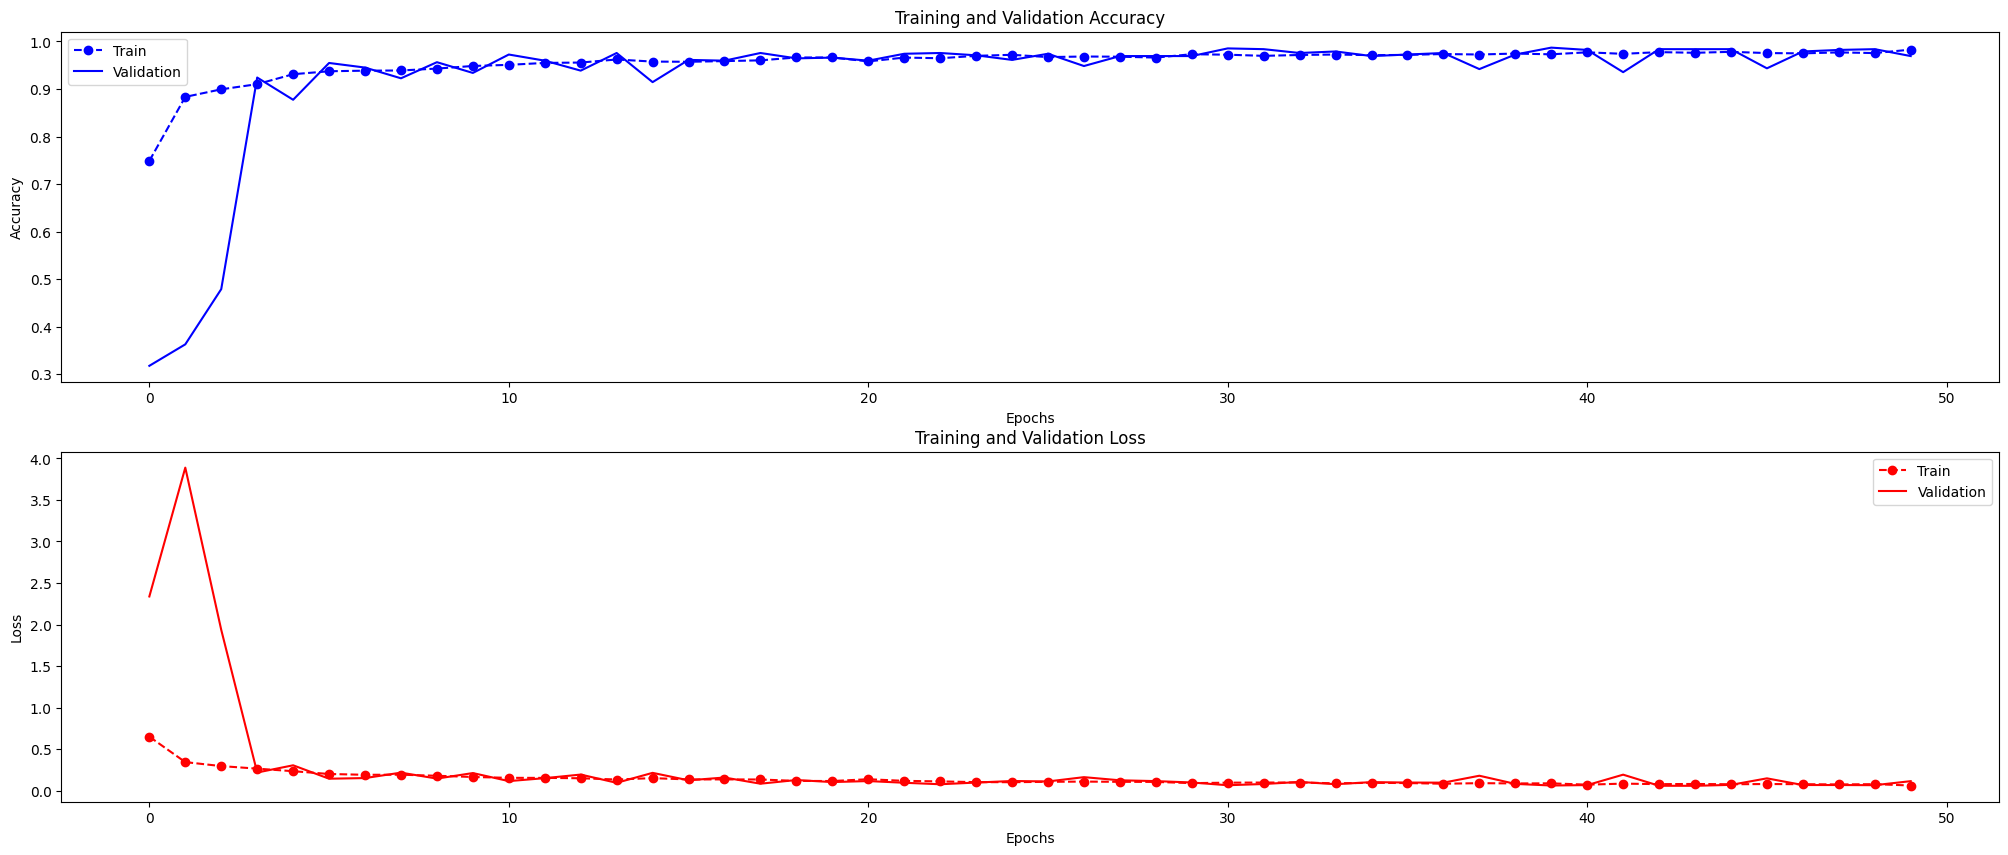

In [9]:
plot_history_csv(os.path.join(models_dir, f'{MODEL_NAME}_history.csv'))